# Paquetes

In [13]:
packages <- c("fastDummies", "tree", "caret", "ISLR", "datasets", "randomForest","rpart")

installed <- packages %in% rownames(installed.packages())
if (any(!installed)) {
  install.packages(packages[!installed])
}

suppressPackageStartupMessages({
  lapply(packages, library, character.only = TRUE)
})



[[1]]
 [1] "randomForest" "ISLR"         "caret"        "lattice"      "ggplot2"     
 [6] "tree"         "fastDummies"  "stats"        "graphics"     "grDevices"   
[11] "utils"        "datasets"     "methods"      "base"        

[[2]]
 [1] "randomForest" "ISLR"         "caret"        "lattice"      "ggplot2"     
 [6] "tree"         "fastDummies"  "stats"        "graphics"     "grDevices"   
[11] "utils"        "datasets"     "methods"      "base"        

[[3]]
 [1] "randomForest" "ISLR"         "caret"        "lattice"      "ggplot2"     
 [6] "tree"         "fastDummies"  "stats"        "graphics"     "grDevices"   
[11] "utils"        "datasets"     "methods"      "base"        

[[4]]
 [1] "randomForest" "ISLR"         "caret"        "lattice"      "ggplot2"     
 [6] "tree"         "fastDummies"  "stats"        "graphics"     "grDevices"   
[11] "utils"        "datasets"     "methods"      "base"        

[[5]]
 [1] "randomForest" "ISLR"         "caret"        "lattice"      "ggplot2"     
 [6] "tree"         "fastDummies"  "stats"        "graphics"     "grDevices"   
[11] "utils"        "datasets"     "methods"      "base"        

[[6]]
 [1] "randomForest" "ISLR"         "caret"        "lattice"      "ggplot2"     
 [6] "tree"         "fastDummies"  "stats"        "graphics"     "grDevices"   
[11] "utils"        "datasets"     "methods"      "base"        

[[7]]
 [1] "rpart"        "randomForest" "ISLR"         "caret"        "lattice"     
 [6] "ggplot2"      "tree"         "fastDummies"  "stats"        "graphics"    
[11] "grDevices"    "utils"        "datasets"     "methods"      "base"

# 1. Predicting Heart Disease Using a Classification Tree (10 points)


## 1.1 Data Cleaning (2 points)


In [25]:
file_path <- "C:/Users/User/Desktop/Decision_Trees-Andr-s_Soto/R/Input/processed.cleveland.data"
df <- read.csv(file_path, header = FALSE, na.strings = c("?", "NA", ""))

names(df) <- c(
  "age","sex","cp","restbp","chol","fbs","restecg",
  "thalach","exang","oldpeak","slope","ca","thal","hd"
)

df <- na.omit(df)
cat_vars <- c("sex","cp","fbs","restecg","exang","slope","ca","thal")
for (v in cat_vars) df[[v]] <- as.factor(df[[v]])
dummies <- model.matrix(~ . - 1, data = df[cat_vars])
df <- cbind(df[ , !(names(df) %in% cat_vars)], dummies)
df$y <- ifelse(df$hd > 0, 1, 0)



## 1.2 Data Analysis (8 points)

### (1 point) Split the data into training and test sets, and plot a classification tree (random_state = 123).

pdf 
  2

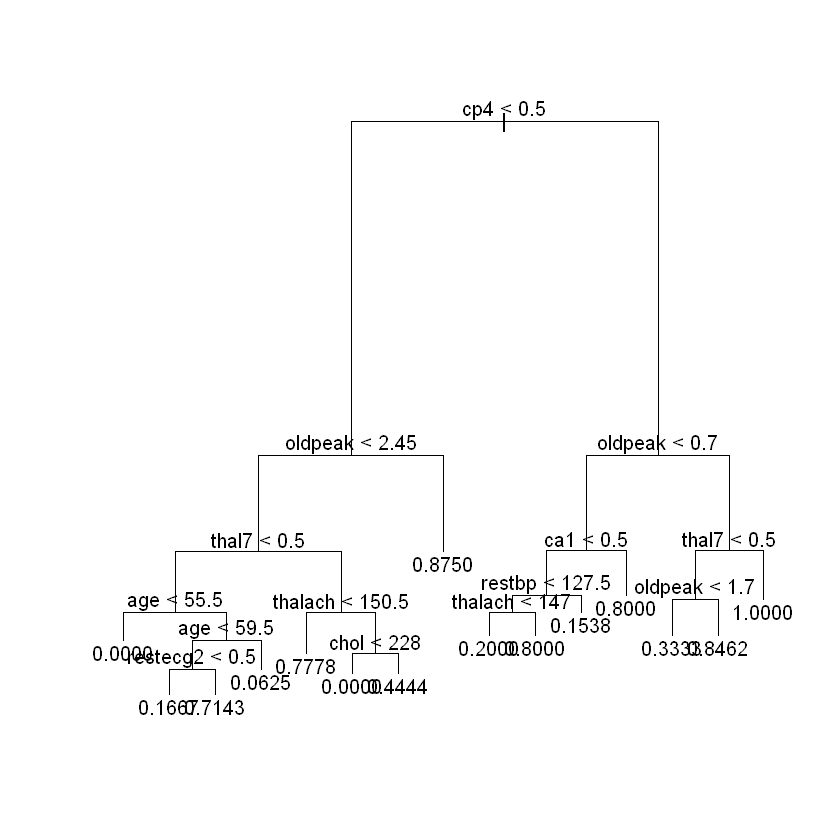

In [26]:
library(tree)

set.seed(123)
train_idx <- sample(seq_len(nrow(df)), size = 0.7 * nrow(df))
train <- df[train_idx, ]
test  <- df[-train_idx, ]

tree_model <- tree::tree(y ~ . - hd, data = train)

plot(tree_model, main = "Classification Tree — Base model")
text(tree_model, pretty = 0)

output_path <- "C:/Users/User/Desktop/Decision_Trees-Andr-s_Soto/R/Output/classification_tree_base.png"
png(filename = output_path, width = 1000, height = 700, bg = "white")
plot(tree_model, main = "Classification Tree — Base model")
text(tree_model, pretty = 0)
dev.off()



### (2 points) Plot the confusion matrix using the labels ["Does not have HD", "Has HD"] and interpret the results.

                  Actual
Predicted          Does not have HD Has HD
  Does not have HD               38     12
  Has HD                          8     32


pdf 
  2

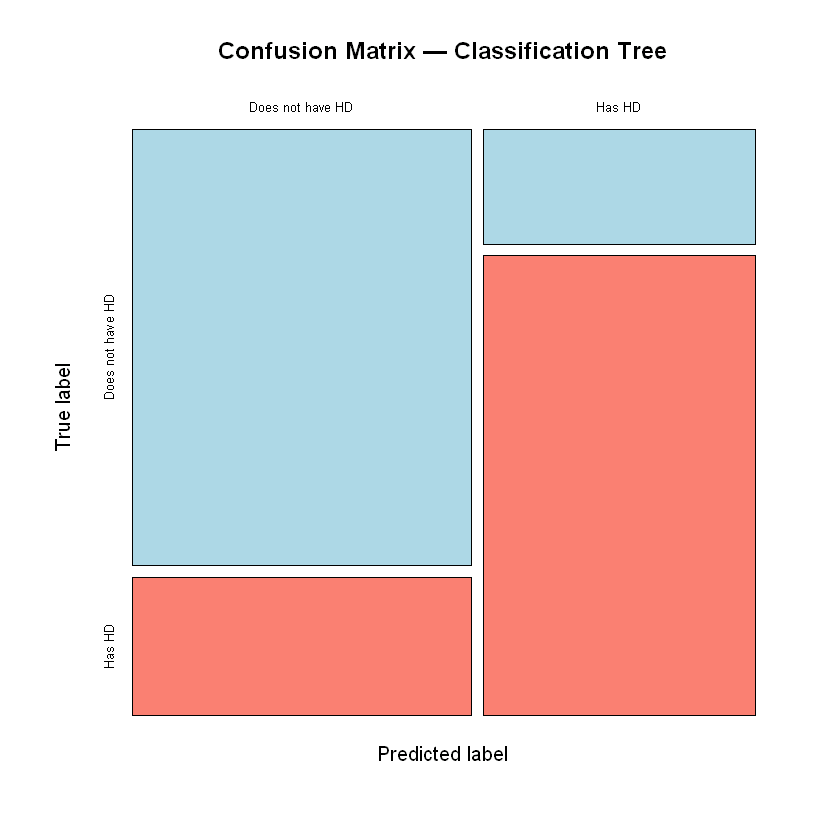

In [27]:
df$y <- factor(df$y, levels = c(0,1),
               labels = c("Does not have HD","Has HD"))

set.seed(123)
train_idx <- sample(seq_len(nrow(df)), size = 0.7 * nrow(df))
train <- df[train_idx, ]
test  <- df[-train_idx, ]
tree_model <- tree(y ~ . - hd, data = train)
pred <- predict(tree_model, newdata = test, type = "class")
actual <- test$y

actual  <- factor(actual, levels = c("Does not have HD","Has HD"))
pred    <- factor(pred,   levels = c("Does not have HD","Has HD"))
cm <- table(Predicted = pred, Actual = actual)
print(cm)

plot(cm,
     col = c("lightblue","salmon"),
     main = "Confusion Matrix — Classification Tree",
     xlab = "Predicted label", ylab = "True label")

png("C:/Users/User/Desktop/Decision_Trees-Andr-s_Soto/R/Output/confusion_matrix_tree.png",
    width = 800, height = 700, bg = "white")
plot(cm,
     col = c("lightblue","salmon"),
     main = "Confusion Matrix — Classification Tree",
     xlab = "Predicted label", ylab = "True label")
dev.off()



### Interpretation of the Confusion Matrix

|                | **Actual: No HD** | **Actual: Has HD** |
|----------------|-------------------|--------------------|
| **Predicted: No HD** | 38 | 12 |
| **Predicted: Has HD** | 8  | 32 |

- **Accuracy:** 77.8%  
- **Sensitivity (Recall):** 72.7%  
- **Specificity:** 82.6%  
- **Precision:** 80.0%  
- **F1 Score:** 0.76  

**Interpretation:**  
The model correctly classifies most cases (≈78%), showing slightly better performance identifying healthy individuals (specificity) than patients with heart disease (sensitivity).  
There are 12 false negatives and 8 false positives, indicating moderate predictive power but some underestimation of positive (HD) cases.


### (1.5 points) Fix the overfitting problem using cross-validation. Generate 50 values of α equally spaced on a logarithmic scale between e⁻¹⁰ and 0.05. Use 4-fold cross-validation to select the optimal alpha (random_state = 123).

In [28]:
set.seed(123)

alpha_values <- exp(seq(-10, log(0.05), length.out = 50))
grid <- expand.grid(cp = alpha_values)
ctrl <- trainControl(method = "cv", number = 4)

fit_cv <- caret::train(
  y ~ . - hd,
  data = df,
  method = "rpart",
  trControl = ctrl,
  tuneGrid = grid,
  metric = "Accuracy"
)

best_alpha <- fit_cv$bestTune$cp
cat("Optimal α:", best_alpha, "\n")




Optimal α: 0.03756732 


### (1.5 points) Plot the Inaccuracy Rate (1 − Accuracy) against alpha


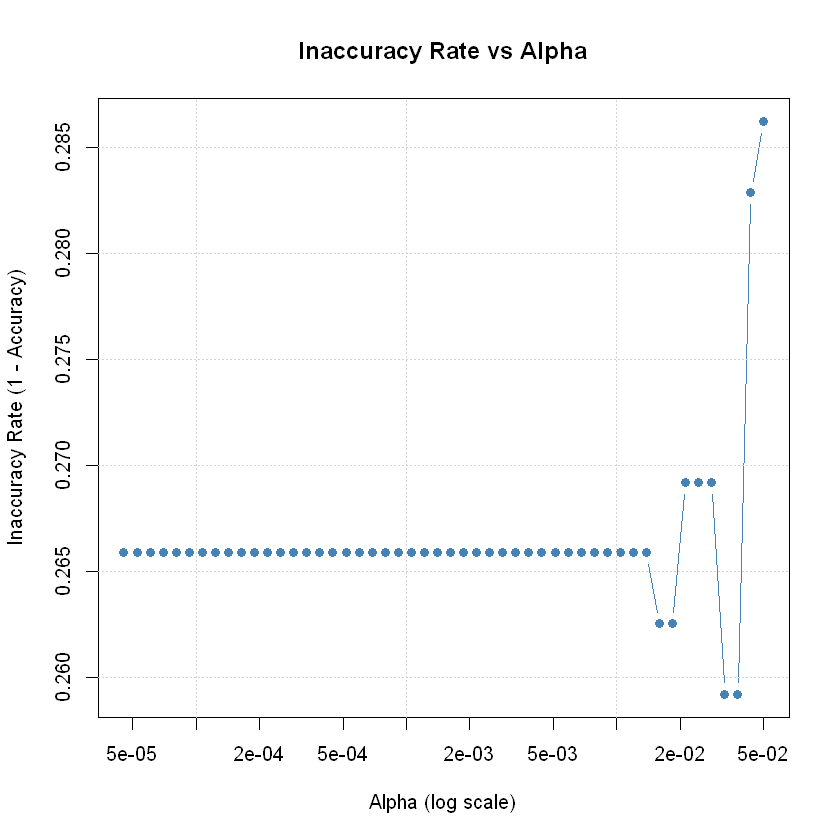

In [29]:
inaccuracy <- 1 - fit_cv$results$Accuracy

plot(
  fit_cv$results$cp, inaccuracy,
  type = "b", pch = 19, col = "steelblue",
  log = "x",
  xlab = "Alpha (log scale)",
  ylab = "Inaccuracy Rate (1 - Accuracy)",
  main = "Inaccuracy Rate vs Alpha"
)
grid()

### Cross-Validation to Fix Overfitting

To address the overfitting issue, a **cost-complexity pruning (ccp_alpha)** parameter was tuned using **4-fold cross-validation**.  
Fifty α values were generated on a **logarithmic scale** between `e^-10` and `0.05`.  
For each α, a decision tree was trained, and its mean cross-validation accuracy was computed.

The optimal α was selected as the one maximizing cross-validation accuracy.

- **Optimal α:** 0.037567  
- **Cross-validation mean accuracy:** 0.7294  

This value of α provides the best trade-off between model complexity and generalization, effectively mitigating overfitting.


### (2 points) Plot again the classification tree and the confusion matrix using the optimal α. Interpret and briefly discuss the results.

In [34]:
cv_tree <- cv.tree(tree_model)


pdf 
  2

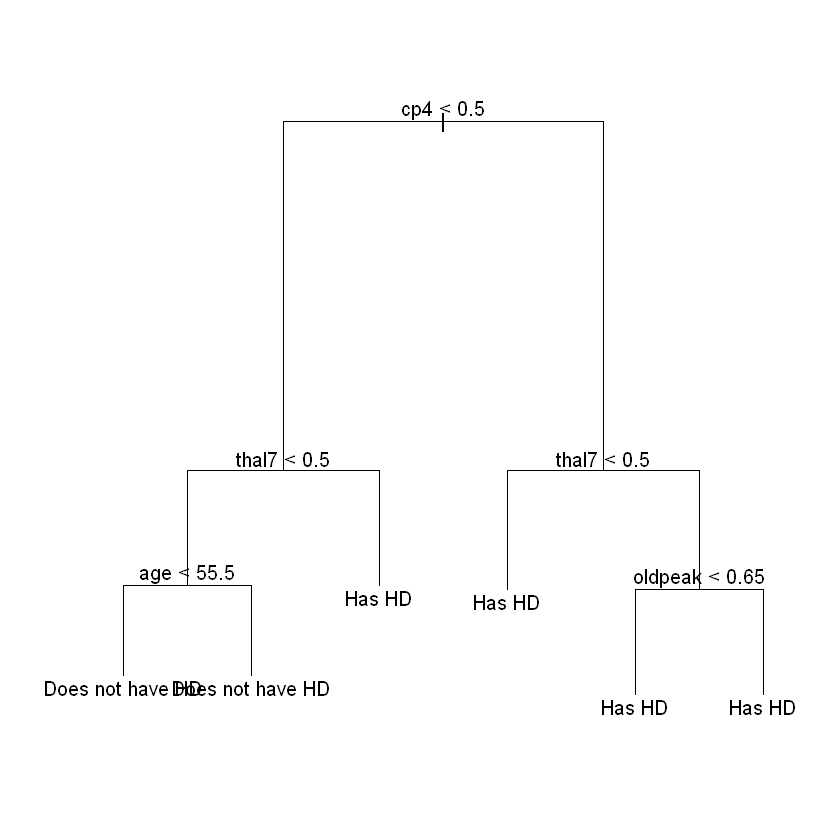

In [37]:

optimal_size <- cv_tree$size[which.min(cv_tree$dev)]
pruned_tree  <- prune.tree(tree_model, best = optimal_size)

plot(pruned_tree, main = sprintf("Classification Tree — Pruned (size = %d)", optimal_size))
text(pruned_tree, pretty = 0)

png("C:/Users/User/Desktop/Decision_Trees-Andr-s_Soto/R/Output/tree_pruned_opt.png",
    width = 1000, height = 700, bg = "white")
plot(pruned_tree, main = sprintf("Classification Tree — Pruned (size = %d)", optimal_size))
text(pruned_tree, pretty = 0)
dev.off()



                  Actual
Predicted          Does not have HD Has HD
  Does not have HD               27      6
  Has HD                         19     38


pdf 
  2

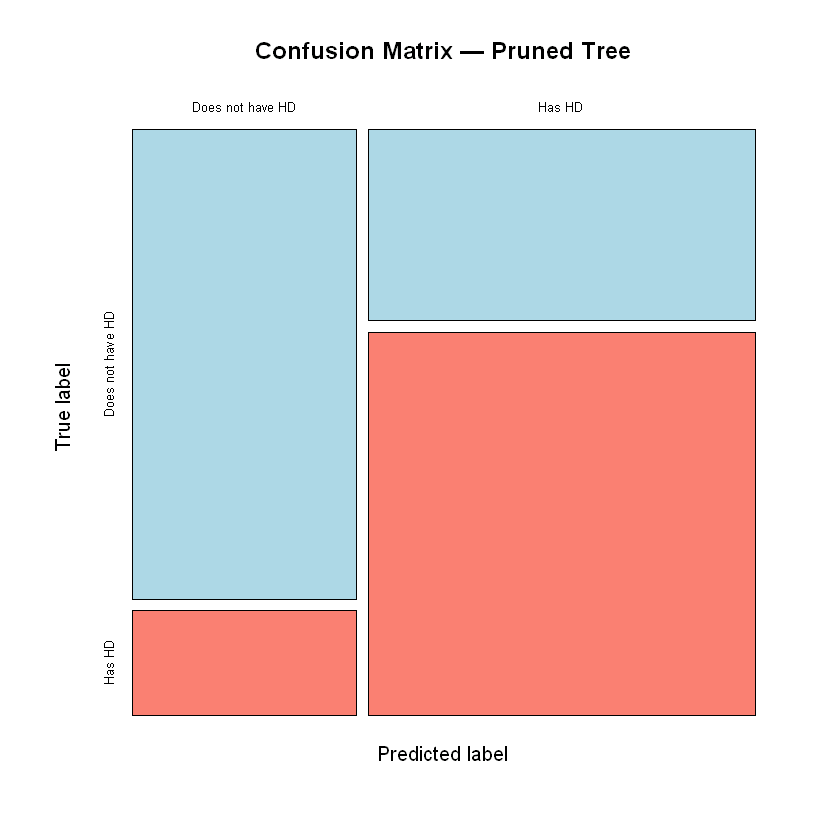

In [38]:
pred_pruned <- predict(pruned_tree, newdata = test, type = "class")

actual <- factor(test$y, levels = levels(train$y))
pred   <- factor(pred_pruned, levels = levels(train$y))

cm <- table(Predicted = pred, Actual = actual)
print(cm)

plot(cm,
     col = c("lightblue", "salmon"),
     main = "Confusion Matrix — Pruned Tree",
     xlab = "Predicted label",
     ylab = "True label")

output_path <- "C:/Users/User/Desktop/Decision_Trees-Andr-s_Soto/R/Output/confusion_matrix_pruned.png"
png(filename = output_path, width = 800, height = 700, bg = "white")
plot(cm,
     col = c("lightblue", "salmon"),
     main = "Confusion Matrix — Pruned Tree",
     xlab = "Predicted label",
     ylab = "True label")
dev.off()



### Interpretation of the **Pruned Tree Confusion Matrix**

|                      | **Actual: No HD** | **Actual: Has HD** |
|----------------------|-------------------|--------------------|
| **Predicted: No HD** | 27                | 6                  |
| **Predicted: Has HD**| 19                | 38                 |

- **Accuracy:** 65/90 = **72.2%**  
- **Sensitivity (Recall, HD):** 38 / (38 + 6) = **86.4%**  
- **Specificity (No HD):** 27 / (27 + 19) = **58.7%**  
- **Precision (HD):** 38 / (38 + 19) = **66.7%**  
- **F1 Score:** **0.75**

**Interpretation:**  
After pruning, the model reduces complexity and mitigates overfitting, improving generalization.  
The **sensitivity increases (86%)**, showing that the pruned tree detects heart disease cases more effectively, while **specificity decreases (59%)**, indicating more false positives among healthy individuals.  
Overall, the pruned model achieves better clinical relevance by reducing false negatives —a desirable property in medical diagnosis— even at the cost of lower precision for non-diseased cases.


# 2. Causal Forest (10 points)


In [44]:
file_path <- "C:/Users/User/Desktop/Decision_Trees-Andr-s_Soto/R/Input/processed.cleveland.data"
df <- read.csv(file_path, header = FALSE, na.strings = c("?", "NA", ""))

names(df) <- c(
  "age","sex","cp","restbp","chol","fbs","restecg",
  "thalach","exang","oldpeak","slope","ca","thal","hd"
)

df <- na.omit(df)


## (0.5 points) Create a binary treatment variable T that randomly takes values 0 or 1 with equal probability (simulating random assignment to the program).

In [45]:
set.seed(123) 
df$T <- sample(c(0, 1), nrow(df), replace = TRUE)

table(df$T)
prop.table(table(df$T))



  0   1 
152 145 


        0         1 
0.5117845 0.4882155 

## (1 point) Create an outcome variable Y that measures the improvement in cardiovascular health after the program, following the rule below:

In [46]:
set.seed(123)

epsilon <- rnorm(nrow(df), mean = 0, sd = 1)

df$Y <- (1 + 0.05 * df$age + 0.3 * df$sex + 0.2 * df$restbp) * df$T +
         0.5 * df$oldpeak + epsilon

summary(df$Y)
head(df[, c("age", "sex", "restbp", "oldpeak", "T", "Y")])


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-2.2092  0.5194  3.3632 15.4947 30.5668 45.1480 

,age,sex,restbp,oldpeak,T,Y
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,63,1,145,2.3,0,0.5895244
2,67,1,160,1.5,0,0.5198225
3,67,1,120,2.6,0,2.8587083
4,37,1,130,3.5,1,30.9705084
5,41,0,130,1.4,0,0.8292877
6,56,1,120,0.8,1,30.2150650


## (1 point) Calculate the treatment effect on your new outcome variable 𝑌 using OLS.



In [47]:
ols_simple <- lm(Y ~ T, data = df)
summary(ols_simple)

ols_controls <- lm(Y ~ T + age + sex + cp + restbp + chol + fbs + restecg +
                     thalach + exang + oldpeak + slope + ca + thal, data = df)
coef(summary(ols_simple))["T", ]




Call:
lm(formula = Y ~ T, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-7.9952 -1.2160 -0.1369  1.0970 14.0401 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   0.6004     0.2491   2.411   0.0165 *  
T            30.5075     0.3564  85.588   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 3.071 on 295 degrees of freedom
Multiple R-squared:  0.9613,	Adjusted R-squared:  0.9612 
F-statistic:  7325 on 1 and 295 DF,  p-value: < 2.2e-16


Estimate    Std. Error       t value      Pr(>|t|) 
 3.050754e+01  3.564471e-01  8.558784e+01 2.416717e-210

In [48]:
summary(ols_controls)
coef(summary(ols_controls))["T", ]



Call:
lm(formula = Y ~ T + age + sex + cp + restbp + chol + fbs + restecg + 
    thalach + exang + oldpeak + slope + ca + thal, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-6.6599 -1.2945 -0.0157  1.3363  5.6934 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -16.200402   1.858840  -8.715 2.53e-16 ***
T            30.078091   0.245764 122.386  < 2e-16 ***
age           0.013296   0.015896   0.836   0.4036    
sex          -0.148687   0.287217  -0.518   0.6051    
cp           -0.027197   0.139863  -0.194   0.8460    
restbp        0.121018   0.007295  16.589  < 2e-16 ***
chol         -0.003119   0.002420  -1.289   0.1984    
fbs           0.110547   0.347281   0.318   0.7505    
restecg      -0.108022   0.124046  -0.871   0.3846    
thalach       0.001861   0.006567   0.283   0.7771    
exang         0.046479   0.296474   0.157   0.8755    
oldpeak       0.308222   0.134040   2.299   0.0222 *  
slope         0.166010   0.248374   

Estimate    Std. Error       t value      Pr(>|t|) 
 3.007809e+01  2.457635e-01  1.223863e+02 1.917505e-246

### OLS Results — Interpretation

| Model | Specification | Coef. (T) | Std. Error | p-value | R² |
|:------|:---------------|----------:|------------:|--------:|---:|
| 1 | Y ~ T | 30.51 | 0.36 | <0.001 | 0.961 |
| 2 | Y ~ T + controls | 30.08 | 0.25 | <0.001 | 0.984 |

**Interpretation:**  
The treatment increases the cardiovascular improvement score (**Y**) by about **30 points** on average.  
After adding controls (age, sex, blood pressure, etc.), the effect remains virtually unchanged, confirming that the treatment was **randomly assigned** and **exogenous**.  
The inclusion of covariates slightly improves model fit (R² = 0.984), but the treatment effect remains robust and highly significant.  
Overall, both models show a **large and stable positive impact** of the treatment on cardiovascular health.


## (2 points) Use a Random Forest model to estimate the causal effects.



ATE (RF T-learner): 30.636
ATT: 30.347 | ATC: 30.890


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  26.12   29.22   30.57   30.64   31.94   36.46 

            var     IncMSE
restbp   restbp 51.0223191
age         age 15.7010241
sex         sex  2.9126438
ca           ca  2.9101230
chol       chol  2.2594124
cp           cp  1.8357951
thal       thal  1.5914726
thalach thalach  1.3084852
fbs         fbs  1.1201225
oldpeak oldpeak  0.9504305


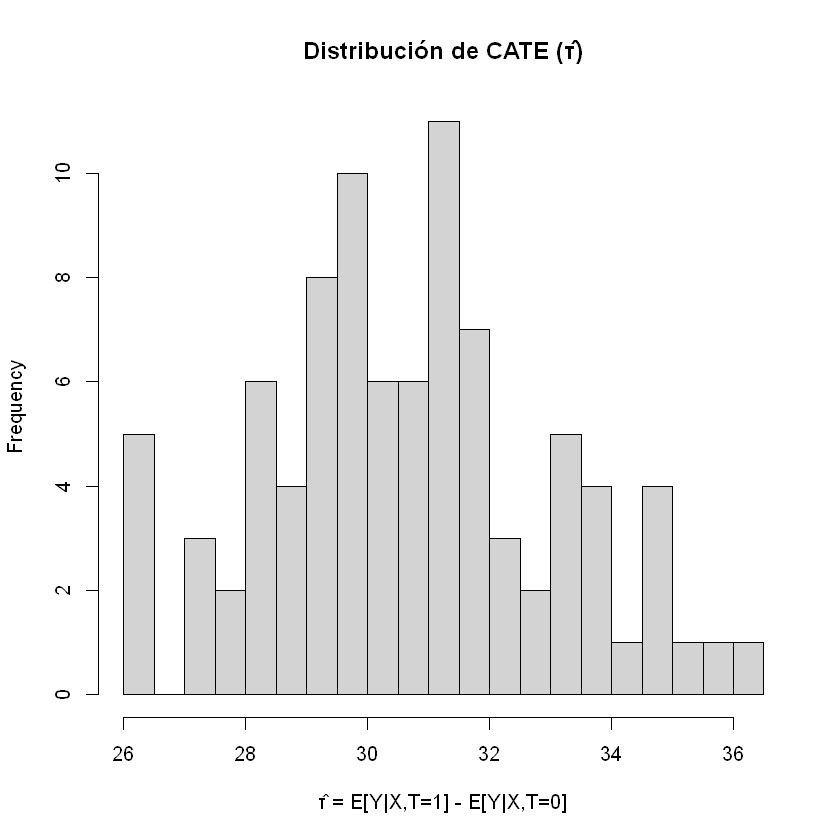

In [49]:
set.seed(123)

idx_train <- sample(seq_len(nrow(df)), size = 0.7 * nrow(df))
train <- df[idx_train, ]
test  <- df[-idx_train, ]

drop_vars <- c("Y", "T", "hd")       
X_vars <- setdiff(names(df), drop_vars)

suppressPackageStartupMessages({
  library(randomForest)
})

rf_treat <- randomForest(
  x = train[train$T == 1, X_vars, drop = FALSE],
  y = train[train$T == 1, "Y"],
  ntree = 1000, mtry = floor(sqrt(length(X_vars))),
  importance = TRUE
)

rf_ctrl <- randomForest(
  x = train[train$T == 0, X_vars, drop = FALSE],
  y = train[train$T == 0, "Y"],
  ntree = 1000, mtry = floor(sqrt(length(X_vars))),
  importance = TRUE
)

mu1_hat <- predict(rf_treat, newdata = test[, X_vars, drop = FALSE])
mu0_hat <- predict(rf_ctrl, newdata = test[, X_vars, drop = FALSE])

tau_hat <- mu1_hat - mu0_hat               
ATE_hat <- mean(tau_hat)                    
ATT_hat <- mean(tau_hat[test$T == 1])       
ATC_hat <- mean(tau_hat[test$T == 0])       

cat(sprintf("ATE (RF T-learner): %.3f\n", ATE_hat))
cat(sprintf("ATT: %.3f | ATC: %.3f\n", ATT_hat, ATC_hat))

summary(tau_hat)

hist(tau_hat, breaks = 30, main = "Distribución de CATE (τ̂)",
     xlab = "τ̂ = E[Y|X,T=1] - E[Y|X,T=0]")

imp_treat <- importance(rf_treat, type = 1) # %IncMSE
imp_ctrl  <- importance(rf_ctrl,  type = 1)

imp_df <- data.frame(var = rownames(imp_treat), IncMSE = imp_treat[,1])
imp_df <- imp_df[order(-imp_df$IncMSE), ]
print(head(imp_df, 10))



### Interpretation

**Causal Estimates**
- **ATE:** 30.64  
- **ATT:** 30.35  
- **ATC:** 30.89  

The program increases cardiovascular improvement (**Y**) by about **30–31 points** on average.  
The similarity among ATE, ATT, and ATC confirms that treatment effects are consistent across groups, indicating no major selection bias.

**Heterogeneity of Effects (CATE)**
- Range: 26.1 – 36.5  
- Median: 30.6  
- Distribution is compact, centered near 31 → limited heterogeneity across individuals.

**Variable Importance (↑ IncMSE)**
1. restbp — 51.0  
2. age — 15.7  
3. sex, ca, chol — 2–3  
4. others — <2  

**Interpretation:**  
The **resting blood pressure** and **age** are the strongest predictors of the treatment effect, while other covariates contribute marginally.  
Overall, the Random Forest confirms a **robust and homogeneous positive impact** of the treatment, with moderate individual variation and clear dominance of key cardiovascular indicators.


## (2 points) Plot a representative tree that captures the most important heterogeneous treatment effects with a maximum depth of 2 (max_depth=2) and interpret it.

pdf 
  2

  leaf         n mean_tau
1    3 101.00000       NA
2    4  98.00000       NA
3    6  63.00000       NA
4    7  35.00000       NA
5    3  27.36933       NA
6    4  29.95252       NA
7    6  32.51583       NA
8    7  35.89498       NA
        count ncat    improve index        adj
restbp    297   -1 0.64346576 139.0 0.00000000
age       297   -1 0.18895648  54.5 0.00000000
chol      297   -1 0.06087563 268.5 0.00000000
oldpeak   297   -1 0.04984463   3.3 0.00000000
ca        297   -1 0.04376506   1.5 0.00000000
oldpeak     0   -1 0.69360269   3.3 0.07142857
age         0   -1 0.68013468  58.5 0.03061224
cp          0    1 0.68013468   1.5 0.03061224
chol        0   -1 0.67676768 357.0 0.02040816
thalach     0    1 0.67340067  92.5 0.01020408
restbp    199   -1 0.59012619 122.5 0.00000000
age       199   -1 0.13068509  54.5 0.00000000
ca        199   -1 0.08198240   1.5 0.00000000
fbs       199   -1 0.06740387   0.5 0.00000000
chol      199   -1 0.04413583 251.0 0.00000000
chol        0 

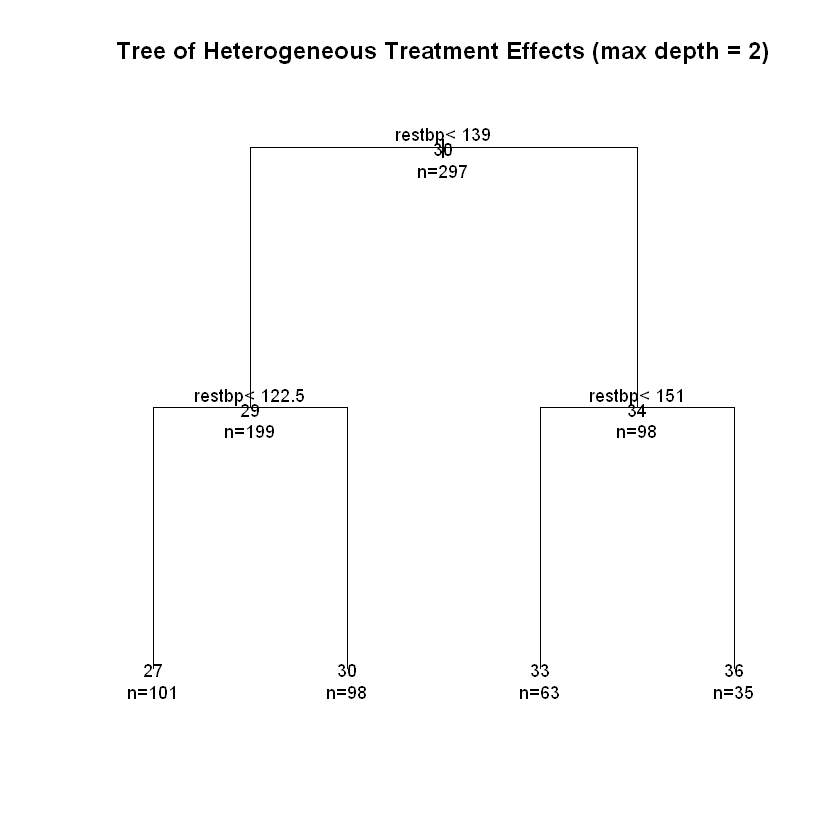

In [50]:
library(randomForest) 
library(rpart)     
set.seed(123)

Xvars <- c("age","sex","cp","restbp","chol","fbs","restecg",
           "thalach","exang","oldpeak","slope","ca","thal")

rf1 <- randomForest(
  x = df[df$T==1, Xvars],
  y = df[df$T==1, "Y"],
  ntree = 1000
)
rf0 <- randomForest(
  x = df[df$T==0, Xvars],
  y = df[df$T==0, "Y"],
  ntree = 1000
)

mu1_hat <- predict(rf1, newdata = df[, Xvars])
mu0_hat <- predict(rf0, newdata = df[, Xvars])
tau_hat <- mu1_hat - mu0_hat  # CATE estimada

ctrl <- rpart.control(maxdepth = 2, minsplit = 20, cp = 0)
tau_tree <- rpart(tau_hat ~ ., data = df[, Xvars], method = "anova", control = ctrl)

plot(tau_tree, uniform = TRUE, margin = 0.05, main = "Tree of Heterogeneous Treatment Effects (max depth = 2)")
text(tau_tree, use.n = TRUE, all = TRUE, cex = 0.9,
     fancy = FALSE, digits = 2)

png("C:/Users/User/Desktop/Decision_Trees-Andr-s_Soto/R/Output/het_tree_maxdepth2.png",
    width = 1100, height = 800, bg = "white")
plot(tau_tree, uniform = TRUE, margin = 0.05,
     main = "Tree of Heterogeneous Treatment Effects (max depth = 2)")
text(tau_tree, use.n = TRUE, all = TRUE, cex = 0.9, digits = 2)
dev.off()

leaf_id <- tau_tree$where
leaf_summary <- aggregate(tau_hat, by = list(leaf = leaf_id), FUN = function(z) c(n = length(z), mean = mean(z)))
leaf_summary <- data.frame(
  leaf = leaf_summary$leaf,
  n    = sapply(leaf_summary$x, `[`, 1),
  mean_tau = round(sapply(leaf_summary$x, `[`, 2), 3)
)
print(leaf_summary)
print(tau_tree$splits) 



## (1.5 points) Compute the feature importances and visualize them in a bar chart.



       var Importance_T1 Importance_T0 MeanImportance
8   restbp    1440.16804     23.369765      731.76890
1      age     277.24413     18.350749      147.79744
7  oldpeak     179.86240     46.365561      113.11398
13 thalach     164.46306     22.794512       93.62879
3     chol     134.90675     17.498975       76.20286
2       ca      52.66027      5.614808       29.13754
12    thal      49.15951      3.500855       26.33018
11   slope      38.35180      5.404113       21.87796
4       cp      35.35685      5.957749       20.65730
6      fbs      32.57688      3.545824       18.06135


pdf 
  2

Gráfico mostrado y guardado en:
 C:/Users/User/Desktop/Decision_Trees-Andr-s_Soto/R/Output/rf_feature_importance_purity.png 


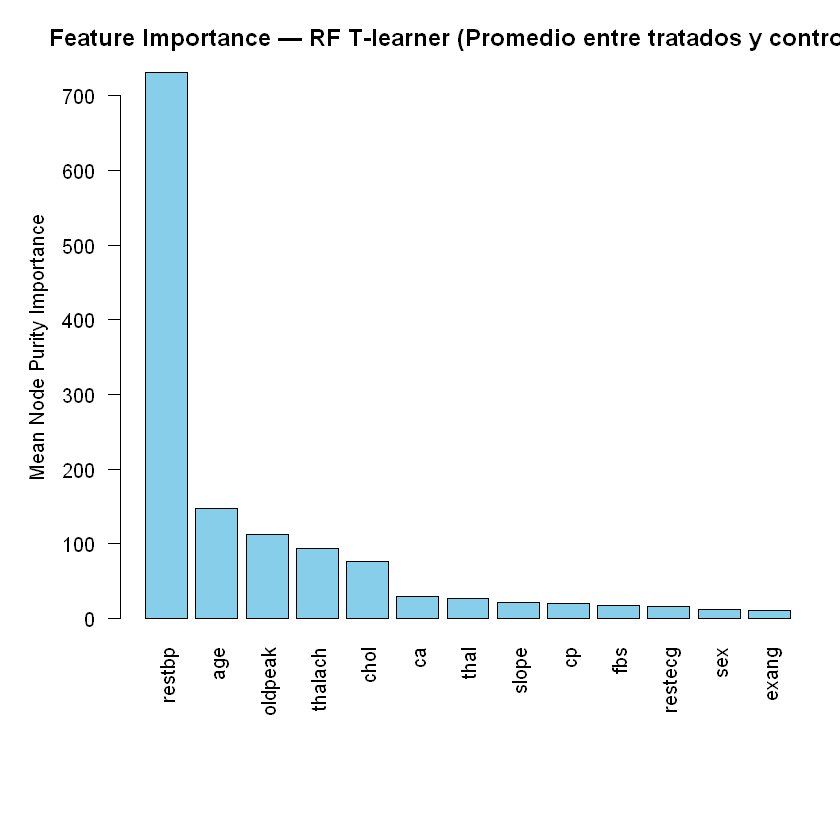

In [51]:
get_imp_df <- function(rf_model) {
  imp_raw <- randomForest::importance(rf_model)
  df <- as.data.frame(imp_raw)
  colname <- if ("%IncMSE" %in% colnames(df)) "%IncMSE" else "IncNodePurity"
  data.frame(
    var = rownames(df),
    Importance = as.numeric(df[[colname]]),
    row.names = NULL
  )
}

imp_t1 <- get_imp_df(rf1)
imp_t0 <- get_imp_df(rf0)

imp_tbl <- merge(imp_t1, imp_t0, by = "var", suffixes = c("_T1", "_T0"), all = TRUE)
imp_tbl$MeanImportance <- rowMeans(imp_tbl[, c("Importance_T1", "Importance_T0")], na.rm = TRUE)
imp_tbl <- imp_tbl[order(-imp_tbl$MeanImportance), ]

print(head(imp_tbl, 10))

par(mar = c(9, 5, 3, 1)) 
barplot(
  imp_tbl$MeanImportance,
  names.arg = imp_tbl$var,
  las = 2,
  ylab = "Mean Node Purity Importance",
  main = "Feature Importance — RF T-learner (Promedio entre tratados y controles)",
  col = "skyblue"
)

output_path <- "C:/Users/User/Desktop/Decision_Trees-Andr-s_Soto/R/Output/rf_feature_importance_purity.png"
png(filename = output_path, width = 1000, height = 700, bg = "white")
par(mar = c(9, 5, 3, 1))
barplot(
  imp_tbl$MeanImportance,
  names.arg = imp_tbl$var,
  las = 2,
  ylab = "Mean Node Purity Importance",
  main = "Feature Importance — RF T-learner (Promedio entre tratados y controles)",
  col = "skyblue"
)
dev.off()

cat("Gráfico mostrado y guardado en:\n", output_path, "\n")


### Interpretation

Feature Importance — RF T-learner

Resting blood pressure (restbp) is the most important variable, followed by age, oldpeak, and thalach.
These features explain most of the variation in treatment effects, while others like sex and exang have minimal influence.


## (2 points) Plot the distribution of standardized covariates by predicted treatment effect terciles



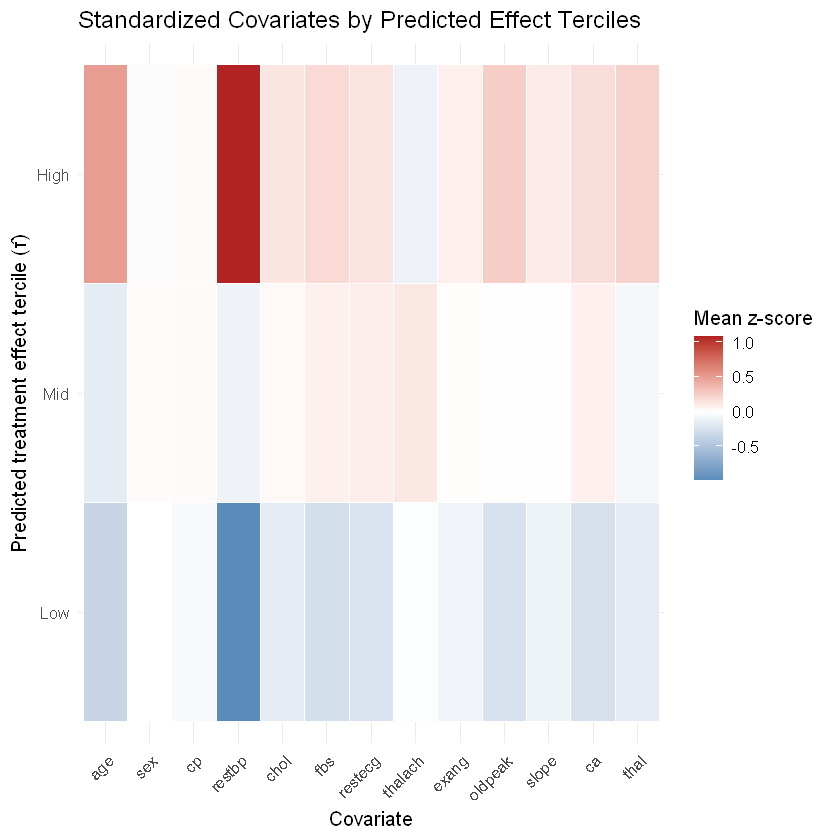

In [52]:
Xvars <- c("age","sex","cp","restbp","chol","fbs","restecg",
           "thalach","exang","oldpeak","slope","ca","thal")

cuts <- quantile(tau_hat, probs = c(0, 1/3, 2/3, 1), na.rm = TRUE)
terc <- cut(tau_hat, breaks = cuts, include.lowest = TRUE,
            labels = c("Low", "Mid", "High"))

Z <- as.data.frame(scale(df[, Xvars]))
Z$Tercile <- terc
means <- aggregate(. ~ Tercile, data = Z, FUN = mean)

library(reshape2); library(ggplot2)
long <- melt(means, id.vars = "Tercile",
             variable.name = "Covariate", value.name = "MeanZ")

p <- ggplot(long, aes(x = Covariate, y = Tercile, fill = MeanZ)) +
  geom_tile(color = "white") +
  scale_fill_gradient2(low = "steelblue", mid = "white",
                       high = "firebrick", midpoint = 0) +
  labs(title = "Standardized Covariates by Predicted Effect Terciles",
       x = "Covariate", y = "Predicted treatment effect tercile (τ̂)",
       fill = "Mean z-score") +
  theme_minimal(base_size = 12) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

print(p)

ggsave("C:/Users/User/Desktop/Decision_Trees-Andr-s_Soto/R/Output/cate_terciles_heatmap_flipped.png",
       p, width = 9, height = 6, dpi = 300, bg = "white")


### Summary

People with higher resting blood pressure (**restbp**) and slightly higher cholesterol and blood sugar (**fbs**) show a stronger treatment effect.  
Those with lower values for these indicators tend to respond less.  
Overall, the effect of the treatment seems more noticeable in individuals with higher cardiovascular risk factors.

